# Predict music genre on spotify data with neural network

For this exercise, we'll use a dataset from Spotify containing music attributes such as bpm, energy, and danceability. It has 45 songs that belong to either the 'rock' genre or the 'dance pop' genre. For this example, as in our lecture, we won't bother to split the data into training and test sets (again, the data here is pretty small).

In [3]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection  import train_test_split

In [4]:
# Read the data
musicFile = './spotify.csv'
musicData = pd.read_csv(musicFile, encoding='latin-1')
musicData.head()

,title,artist,top genre,bpm,energy,danceability,liveness,valence,acousticness,speechiness
0,Highway to Hell,AC/DC,rock,116,91,57,16,42,6,13
1,Back In Black,AC/DC,rock,188,70,31,8,76,1,5
2,Thunderstruck,AC/DC,rock,134,89,50,22,26,0,4
3,Sweet Home Alabama,Lynyrd Skynyrd,rock,98,61,60,9,89,18,3
4,Fortunate Son,Creedence Clearwater Revival,rock,133,66,64,15,66,20,4


The first step is to define the dataset. 

Make a new column in the dataframe called 'genre_class'. Set it to be 0 for 'rock' and 1 for 'dance pop' (these are the only genres in the dataset).

We need to get our pandas data into torch tensors. One way to do this is to first convert them to numpy arrays and then call `torch.from_numpy()` on the numpy arrays. We'll want to set the `dtype='float32'` when we call `np.array()` on the pandas columns.

Define the musical attributes ('bpm' through 'speechiness') as a pytorch tensor called `features`.

Define a pytorch tensor called `targets`  based on the column `genre_class`.



In [5]:
musicData["genre_class"] =  np.where(musicData['top genre'] == 'rock', 0, 1)
musicData = musicData.drop(columns=["top genre"])
to_torch = musicData.iloc[:, 2:-1]
class_ = musicData.iloc[:, -1:]

features = torch.from_numpy(np.array(to_torch, dtype='float32')) 
targets = torch.from_numpy(np.array(class_, dtype='float32')) 

Now create a TensorDataSet from `features` and `targets` called `train_ds`.

Also create a DataLoader called `train_dl` from `train_ds` using `batch_size=10` and `shuffle=True`. 

In [6]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(features, targets)

train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)

Note that we can see the shapes of tensors drawn from the dataloader with our given batch size:

In [7]:
x1,y1=next(iter(train_dl)) # pull a single x,y from the data loader
print(x1.shape)
print(y1.shape)

torch.Size([10, 7])
torch.Size([10, 1])


If we wanted to pass these through a loss function, we would likely have to alter the shape of the `y`, to something that our loss function can understand. We can do this with a `.view(-1,1)` operation, which will make it a tensor with 90 rows and 1 column (instead of a 1d tensor), like so:

In [8]:
y1.view(-1,1)
print(y1.view(-1,1).shape) # this will output a shape of [batch_size,1]

torch.Size([10, 1])


For our neural network model we'll use a single fully connected layer (`torch.nn.Linear()`), followed by a sigmoid activation function (`torch.nn.Sigmoid()`). 

Note that `torch.nn.Linear()` takes two arguments that specify the size of the input and output. You'll have to figure out what these should be based on the data. Remember that we want to connect all the features to a single output that is then passed through the activation function. `torch.nn.Sigmoid()` does not need any arguments.

We can create a model object from these two layers by passing them as arguments to `torch.nn.Sequential()`. This will make a neural network that connects the output of each layer to the input of the next.

By using the sigmoid function, the output of the fully connected layers is converted into a value between 0 and 1. If the converted value is larger than 0.5, we will interpret this as the model predicting the genre of a music to be 'dance pop' (since we set `genre_class=1` for 'dance pop'. Otherwise, the model predicts the genre to be 'rock' music.

We'll set the random seed of pytorch manually, using `torch.manual_seed(0)` just to ensure that we are all working on the same shuffled sequence. This step is not needed in general when you train a NN with shuffling, but just included to make sure we're all on the same page.

In [9]:
torch.manual_seed(0)

model = torch.nn.Sequential(torch.nn.Linear(x1.shape[1], y1.shape[1]), torch.nn.Sigmoid()) 

Now instantiate an SGD optimizer using `torch.optim.SGD()`. We can use a learning rate of `lr=1e-4`.

For the loss function, we'll use the binary cross entropy loss, `torch.nn.BCELoss()` with the argument `reduction='mean'`. BCELoss is often used in logistic regression.

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4) 
loss_function = torch.nn.BCELoss(reduction='mean')

Now write the code for training the model over 1000 epochs. You can look back at my `fit()` function defined in the lecture. You don't need to write this as a function, but can instead just write the code directly.

The model will be trained for 1000 epochs (i.e., you need to loop over epochs).

When you call `loss_function`, on the predictions (`pred`) and the targets (`yb`), you will need to adjust the shape of the targets, as explained above.

We can calculate a running_loss for each epoch by setting `running_loss=0` before looping over the items in `train_dl`.  We can add up the contribution from each batch to the running loss by adding a line `running_loss+=loss.item()` after calling `loss.backward()`.

Finally, we may like to print out the loss for some epochs (there are 1000 epochs, so its overkill to print out the loss for each one). Instead we can print out the loss for only certain values of the epoch -- for example when the epoch divided by 100 has a remainder of 99, or `epoch%100==99`. When this occurs, print out the average loss for that epoch, `running_loss/len(train_dl)`. 

You can also try your hand at calculating either the average training accuracy for an epcoh or the "last batch training accuracy" of the model at these particular epochs.

In [11]:
n_epochs = 1000
model.train()
for epoch in range(n_epochs):
  running_loss = 0
  for xb, yb in train_dl:
    optimizer.zero_grad()
    pred = model(xb)
    loss = loss_function(pred, yb.view(-1,1))
    loss.backward()
    running_loss+=loss.item()
    optimizer.step()
  if (epoch%100==99):
    print("Average loss is: ", running_loss/len(train_dl))

Average loss is:  0.5690520571337806
Average loss is:  0.4071001609166463
Average loss is:  0.40008948577774894
Average loss is:  0.39151937928464675
Average loss is:  0.4067053861088223
Average loss is:  0.3969957083463669
Average loss is:  0.3925536556376351
Average loss is:  0.38820408946937984
Average loss is:  0.3951929642094506
Average loss is:  0.3979148417711258


Finally, when the model has been fully trained, let's look at a prediction for a particular song. We'll predict the genre of Ariana Grande's "no tears left to cry." This song is classified as 'dance pop' in the Spotify. Here's the music video:

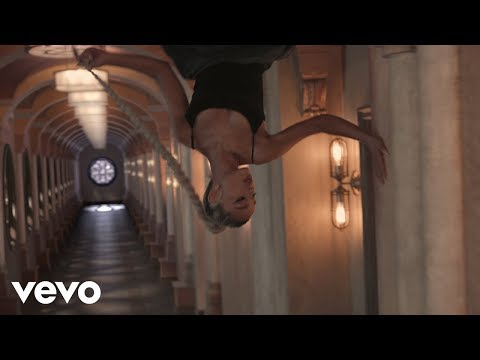

In [12]:
from IPython.display import YouTubeVideo
YouTubeVideo('ffxKSjUwKdU',width=400,height=300)

This particular song has the features (bpm, energy, danceability, liveness, valence, acousticness, speechiness): [122, 71, 70, 29, 35, 4, 6]

Get the prediction for this particular song by passing the appropriate input into the model to get the output. How do you interpret this output?

In [13]:
result = model(torch.from_numpy(np.array([122., 71., 70., 29., 3.5, 4., 6.], dtype='float32')))
result

tensor([0.9891], grad_fn=<SigmoidBackward0>)

**As this result is very close to 1, the interpretation of this result is that the model predicts this to be a dance pop song (class = 1).**

## Part 2
- Split the data into training set and test set and compute accuracy on test set.
- Try different model architectures and see its impact on accuracy on the test set. Possible changes to model architectures including but not limited to: number of hidden layers, number neuron in each layer, different activation functions.

In [49]:
train_ds2, test_ds = torch.utils.data.random_split(train_ds,[80, 10])

train2_dl = DataLoader(train_ds2, batch_size=10, shuffle=True)

test_dl = DataLoader(test_ds, batch_size=10, shuffle=True)

train_x1, train_y1 = next(iter(train2_dl)) 
test_x1, test_y1 = next(iter(test_dl)) 
#print(x1.shape)

torch.manual_seed(0)

def fit(num_epochs, model, loss_function, optimizer):
  #print(model)
  #print(loss_function)
  #print(optimizer)
  n_epochs = 1000
  model.train()
  for epoch in range(n_epochs):
    running_loss = 0
    for xb, yb in train2_dl:
      optimizer.zero_grad()
      pred = model(xb)
      loss = loss_function(pred, yb.view(-1,1))
      loss.backward()
      running_loss+=loss.item()
      optimizer.step()
    if (epoch%100==99):
      print("Average training loss is: ", running_loss/len(train_dl))

  test_loss = 0
  for xb, yb in test_dl:
    pred = model(xb)
    loss = loss_function(pred, yb.view(-1,1))
    test_loss += loss.item()
    print("Test loss is: ", test_loss/len(train_dl))
  print("-----------------")


model = torch.nn.Sequential(torch.nn.Linear(train_x1.shape[1], train_y1.shape[1]), torch.nn.Sigmoid())
fit(1000, model,(torch.nn.BCELoss(reduction='mean')), torch.optim.SGD(model.parameters(), lr=1e-4))

model2 = torch.nn.Sequential(torch.nn.Linear(train_x1.shape[1], train_y1.shape[1]), torch.nn.ReLU(), torch.nn.Sigmoid())
fit(10000, model2,(torch.nn.MSELoss(reduction='mean')), torch.optim.Adagrad(model2.parameters(), lr=1e-3))

model3 = torch.nn.Sequential(torch.nn.Linear(train_x1.shape[1], train_y1.shape[1]), torch.nn.ReLU(), torch.nn.Tanh(), torch.nn.Sigmoid())
fit(10000, model3,(torch.nn.BCELoss(reduction='mean')), torch.optim.SGD(model3.parameters(), lr=1e-3))

model4 = torch.nn.Sequential(torch.nn.Linear(train_x1.shape[1], train_y1.shape[1]), torch.nn.ReLU(), torch.nn.Tanh(), torch.nn.Sigmoid())
fit(10000, model4,(torch.nn.MSELoss(reduction='mean')), torch.optim.SGD(model4.parameters(), lr=1e-3))


Average training loss is:  0.48392866055170697
Average training loss is:  0.3520390060212877
Average training loss is:  0.32234712110625374
Average training loss is:  0.31877787825134063
Average training loss is:  0.32549121810330284
Average training loss is:  0.31433502005206215
Average training loss is:  0.3141484061876933
Average training loss is:  0.31100918187035453
Average training loss is:  0.3111894362502628
Average training loss is:  0.3021264473597209
Test loss is:  0.10169082217746311
-----------------
Average training loss is:  0.4444444543785519
Average training loss is:  0.4444444576899211
Average training loss is:  0.4444444527228673
Average training loss is:  0.4444444510671828
Average training loss is:  0.4444444560342365
Average training loss is:  0.4444444510671828
Average training loss is:  0.4444444543785519
Average training loss is:  0.4444444527228673
Average training loss is:  0.4444444469279713
Average training loss is:  0.4444444444444444
Test loss is:  0.0555